In [1]:
from sklearn.cluster import BisectingKMeans
from dsipts import read_public_dataset,TimeSeries
import pickle
import matplotlib.pyplot as plt
data, columns = read_public_dataset(  dataset= 'weather', path= '/home/agobbi/Projects/ExpTS/data')
ts = TimeSeries('prova')
use_covariates = False
ts.load_signal(data, enrich_cat=  ['hour'],target_variables=['y'], past_variables=columns if use_covariates else [])
train,validation,test= ts.split_for_train(  perc_train= 0.8,  perc_valid= 0.1,  shift= 0,  skip_step=1,past_steps=15,future_steps=48)
token_split = 4
max_voc_size = 256
samples,length,_ = train.data['y'].shape
tmp = train.data['x_num_past']

/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


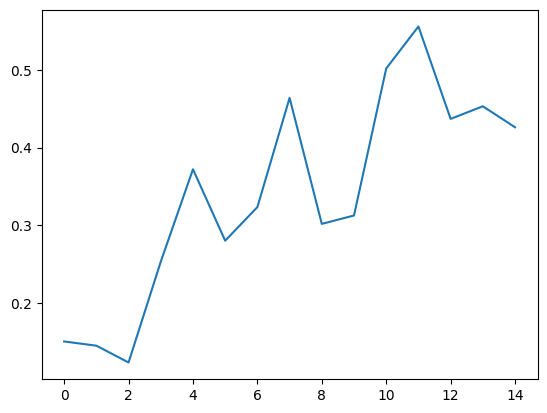

In [2]:

plt.plot(tmp[0])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
x = torch.tensor(tmp[0:10])

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings.view(input_shape[0],-1,encodings.shape[1])



In [5]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
   
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings.view(input_shape[0],-1,encodings.shape[1])


In [6]:
class Residual(nn.Module):

    def __init__(self, in_channels, hidden_channels, num_residual_hiddens):
        super(Residual, self).__init__()
        
        relu_1 = nn.ReLU(True)
        conv_1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=num_residual_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )


        relu_2 = nn.ReLU(True)
        conv_2 = nn.Conv1d(
            in_channels=num_residual_hiddens,
            out_channels=hidden_channels,
            kernel_size=1,
            stride=1,
            bias=False
        )


        # All parameters same as specified in the paper
        self._block = nn.Sequential(
            relu_1,
            conv_1,
            relu_2,
            conv_2
        )
    
    def forward(self, x):
        return x + self._block(x)
    
class ResidualStack(nn.Module):

    def __init__(self, in_channels, hidden_channels, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, hidden_channels, num_residual_hiddens)] * self._num_residual_layers)
        
    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels,num_residual_layers=3):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv1d(in_channels=in_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=3, padding=1)
        
        self._conv_2 = nn.Conv1d(in_channels=hidden_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=3,padding=1)

        self._conv_3 = nn.Conv1d(in_channels=hidden_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_4 = nn.Conv1d(in_channels=hidden_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=3,
                                 padding=1)
        
        self._conv_5 = nn.Conv1d(in_channels=hidden_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=3, padding=1)

        self._residual_stack = ResidualStack(
                in_channels=hidden_channels,
                hidden_channels=hidden_channels,
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=hidden_channels//2
        )
    def forward(self, inputs):
        x_conv_1 = F.relu(self._conv_1(inputs))
        x = F.relu(self._conv_2(x_conv_1)) + x_conv_1
        x_conv_3 = F.relu(self._conv_3(x))
        x_conv_4 = F.relu(self._conv_4(x_conv_3)) + x_conv_3
        x_conv_5 = F.relu(self._conv_5(x_conv_4)) + x_conv_4
        x = self._residual_stack(x_conv_5) + x_conv_5
        

        return x

In [7]:
E = Encoder(1,14)
print(x.permute(0, 2, 1).shape)
x_t = E(x.permute(0, 2, 1)) ##BxCxL
x_t.shape

torch.Size([10, 1, 15])


torch.Size([10, 14, 7])

In [8]:

class Jitter(nn.Module):
    """
    Jitter implementation from [Chorowski et al., 2019].
    During training, each latent vector can replace either one or both of
    its neighbors. As in dropout, this prevents the model from
    relying on consistency across groups of tokens. Additionally,
    this regularization also promotes latent representation stability
    over time: a latent vector extracted at time step t must strive
    to also be useful at time steps t − 1 or t + 1.
    """

    def __init__(self, probability=0.12):
        super(Jitter, self).__init__()

        self._probability = probability

    def forward(self, quantized):
        original_quantized = quantized.detach().clone()
        length = original_quantized.size(2)
        for i in range(length):
            """
            Each latent vector is replace with either of its neighbors with a certain probability
            (0.12 from the paper).
            """
            replace = [True, False][np.random.choice([1, 0], p=[self._probability, 1 - self._probability])]
            if replace:
                if i == 0:
                    neighbor_index = i + 1
                elif i == length - 1:
                    neighbor_index = i - 1
                else:
                    """
                    "We independently sample whether it is to
                    be replaced with the token right after
                    or before it."
                    """
                    neighbor_index = i + np.random.choice([-1, 1], p=[0.5, 0.5])
                quantized[:, :, i] = original_quantized[:, :, neighbor_index]

        return quantized

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_channels,out_channels,num_residual_layers=3):
        super(Decoder, self).__init__()
        
        
        #self._jitter = Jitter(0.125)
        
        self._conv_1 = nn.Conv1d(in_channels=in_channels,
                                 out_channels=hidden_channels,
                                 kernel_size=3, 
                                 padding=1)
        
        self._upsample = nn.Upsample(scale_factor=2)
        
        self._residual_stack = ResidualStack(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=hidden_channels//2
        )
        
        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=hidden_channels, 
                                                out_channels=hidden_channels,
                                                kernel_size=3,  padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose1d(
                                                in_channels=hidden_channels, 
                                                out_channels=hidden_channels,
                                                kernel_size=4,padding=2)
        
        self._conv_trans_3 = nn.ConvTranspose1d(in_channels=hidden_channels, 
                                                out_channels=out_channels,
                                                kernel_size=4,  padding=1)

    def forward(self, x,is_training=True):
        #if is_training:
        #     x = self._jitter(x)
        x = self._conv_1(x)
        x = self._upsample(x)
        x = self._residual_stack(x)
        x = F.relu(self._conv_trans_1(x))
        x = F.relu(self._conv_trans_2(x))
        x = self._conv_trans_3(x)
        return x

In [10]:
import numpy as np
D = Decoder(14,6,1)
D(x_t).shape
##BxCxL


torch.Size([10, 1, 14])

In [11]:
class Model(nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels,num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(in_channels, hidden_channels)
        self._pre_vq_conv = nn.Conv1d(in_channels=hidden_channels, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(in_channels=embedding_dim,hidden_channels=hidden_channels,out_channels=out_channels)


    def forward(self, x,is_training=True):
        z = self._encoder(x)

        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, encodings = self._vq_vae(z)
        x_recon = self._decoder(quantized,is_training)

        return loss, x_recon, perplexity,quantized,encodings

In [12]:
from torch.utils.data import DataLoader

training_loader = DataLoader(tmp, 
                             batch_size=128, 
                             shuffle=True,
                             pin_memory=True)

In [14]:
model = Model(in_channels=1,
              hidden_channels=64, 
              out_channels=1,
              num_embeddings=128,
              embedding_dim=128, commitment_cost=0.1, decay=0.0)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, amsgrad=False)
model.train()
num_training_updates=100000
train_res_recon_error = []
train_res_perplexity = []
device = 'cpu'

for i in range(num_training_updates):
    data = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity,quantized,encodings = model(data.permute(0,2,1))
    recon_error = F.mse_loss(data_recon, data) 
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 1000 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

/tmp/ipykernel_24317/1667347900.py:21: UserWarning: Using a target size (torch.Size([128, 15, 1])) that is different to the input size (torch.Size([128, 1, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_error = F.mse_loss(data_recon, data)


1000 iterations
recon_error: 0.108
perplexity: 4.024

2000 iterations
recon_error: 0.100
perplexity: 3.756

3000 iterations
recon_error: 0.108
perplexity: 3.937

4000 iterations
recon_error: 0.102
perplexity: 3.941

5000 iterations
recon_error: 0.088
perplexity: 5.643

6000 iterations
recon_error: 0.089
perplexity: 5.428

7000 iterations
recon_error: 0.087
perplexity: 6.357

8000 iterations
recon_error: 0.080
perplexity: 7.875

9000 iterations
recon_error: 0.084
perplexity: 7.934

10000 iterations
recon_error: 0.079
perplexity: 9.938

11000 iterations
recon_error: 0.080
perplexity: 9.523

12000 iterations
recon_error: 0.081
perplexity: 10.049

13000 iterations
recon_error: 0.076
perplexity: 10.241

14000 iterations
recon_error: 0.078
perplexity: 10.699

15000 iterations
recon_error: 0.077
perplexity: 11.803

16000 iterations
recon_error: 0.078
perplexity: 11.576

17000 iterations
recon_error: 0.077
perplexity: 12.198

18000 iterations
recon_error: 0.080
perplexity: 13.333

19000 iterat

In [59]:
loss


tensor(0.0974, grad_fn=<AddBackward0>)

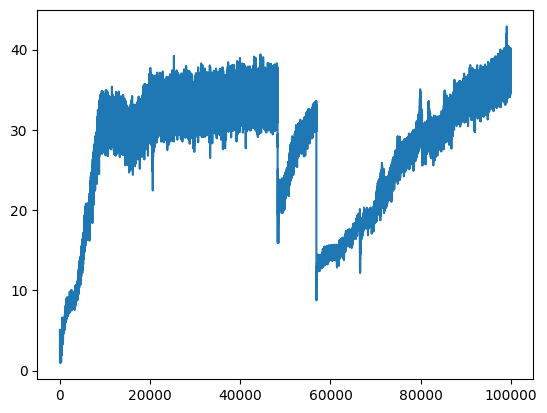

In [60]:
plt.plot(train_res_perplexity)

In [61]:
torch.argmax(encodings,2)

tensor([[ 37,  30,  30,  16, 114, 120,  95],
        [ 72,  44,  53,  94,  35,  68,  21],
        [  0,  82,  28, 120,   4,  41, 118],
        [120,  94,  35,  26,  58, 106,  53],
        [ 72,  53, 120,  94,  77,  95,  82],
        [ 68,   4,  98,  92,  69,  53,  68],
        [120,  94,  35,  26,  58,  98,  53],
        [106,  92,  92,  58,  65,  30, 120],
        [120,  94,  35,  26,  14,  98,  53],
        [120,  94,  94, 114,  58,   4,  44],
        [  4,  35,  35,  26,  14,  98,  53],
        [  4,  35,  35,  26,  14,  98,  53],
        [103,  64,  24,   0,   0,  64, 103],
        [ 95,   4, 106,  77,  69,  44,  28],
        [ 59, 119,  59,  78,  59,  59,  59],
        [112,   0,  82,  53,  53,  74,  97],
        [ 28,  37, 120,  35,  92,  12,  72],
        [112, 118,   0,  68,  68,  97,  24],
        [ 68,  37, 120,  35,  92,  12,  72],
        [ 72,  53, 120,  94,  77,  95,  21],
        [ 21,  95,  44,  30,  20,  72,   0],
        [ 37,  20,  94, 114,  26,   4,  44],
        [ 

In [484]:
quantized.shape

torch.Size([30, 32, 8])

In [477]:
vq_loss, data_recon, perplexity,quantized,encodings_x = model(data[0:30].permute(0,2,1),False)
vq_loss, data_recon, perplexity,quantized,encodings_y = model(data[0:30].permute(0,2,1),False)

In [479]:
encodings.argmax(dim=2).shape

torch.Size([64, 8])

In [448]:
from minigpt import GPT
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = 128
model_config.block_size = 8+8 -1
trans = GPT(model_config)

number of parameters: 2.70M


In [476]:
trans(encodings.argmax(dim=2)[0:1])

(tensor([[[ 0.2571,  0.0743, -0.1801,  ..., -0.2465, -0.0404,  0.1106],
          [ 0.1221,  0.2051,  0.0380,  ..., -0.4007, -0.0010,  0.0805],
          [ 0.1666,  0.1352, -0.3188,  ..., -0.1891,  0.3921, -0.2439],
          ...,
          [ 0.1980,  0.2870, -0.3885,  ..., -0.3751,  0.1064,  0.0598],
          [ 0.0058,  0.0642, -0.0312,  ...,  0.2215,  0.4970, -0.3951],
          [ 0.2371,  0.1826,  0.0691,  ...,  0.2225,  0.1072, -0.0570]]],
        grad_fn=<UnsafeViewBackward0>),
 None)

In [482]:
torch.cat([encodings.argmax(dim=2),encodings.argmax(dim=2)[:,0:-1]],1).shape


torch.Size([64, 15])

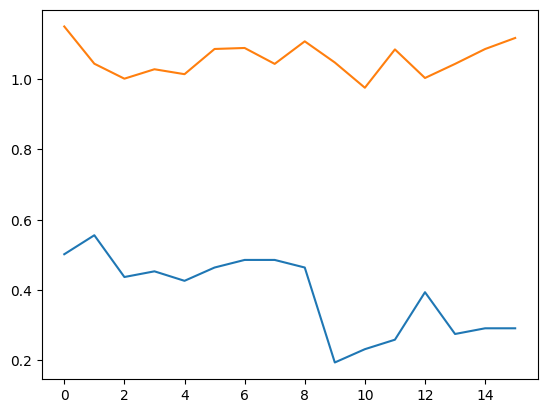

In [480]:
plt.plot(tmp[10].flatten())
plt.plot(data_recon[10].detach().cpu().flatten())

In [369]:
encodings.argmax(2)

tensor([[223, 223, 223, 223, 223, 223, 223, 223],
        [223, 200, 200, 200, 200, 200, 200, 200],
        [223, 223, 223, 223, 223, 200, 223, 223],
        [223, 223, 223,  74,  74,  74,  74,  74],
        [223, 223, 223, 223, 223,  74,  74,  74],
        [223, 223, 223, 223, 223, 223, 223,  74],
        [223,  74,  74,  74,  74,  74,  74,  74],
        [ 74,  74,  74,  74,  74,  74,  74,  74],
        [223, 200, 200, 200, 200, 200, 200, 200],
        [200, 200, 200, 200, 200, 200, 200, 200],
        [223, 223, 223, 200, 200, 200, 200, 200],
        [ 74,  74,  74,  74,  74,  74,  74,  74],
        [223, 223, 223, 223, 223, 223, 223,  74],
        [223, 223, 223, 223, 223, 223, 223, 223],
        [223, 223, 223, 223, 223, 223, 223, 223],
        [223, 223, 223,  74, 223, 223, 223,  74],
        [223, 223, 223, 223, 223, 223, 223, 223],
        [223, 223, 223, 223, 223, 223, 223, 223],
        [200, 200, 200, 200, 200, 200, 200, 200],
        [223, 223, 223, 223, 223, 223, 223, 223],


In [133]:
encodings

tensor([[0, 0, 0, 0]])

In [76]:
import numpy as np
import matplotlib.pyplot as plt


In [77]:
from scipy.stats import bootstrap
res = []
sample = y_train[10]
for index in sample:
    data=tmp[np.where(clusters==index)[0]]

    for i in range(data.shape[1]):

        bootstrap_ci = bootstrap((data[:,i],), np.median,n_resamples=100, confidence_level=0.9,
                                 random_state=1, method='percentile')

        res.append([bootstrap_ci.confidence_interval.low,np.median(data[:,i]),bootstrap_ci.confidence_interval.high])



NameError: name 'y_train' is not defined

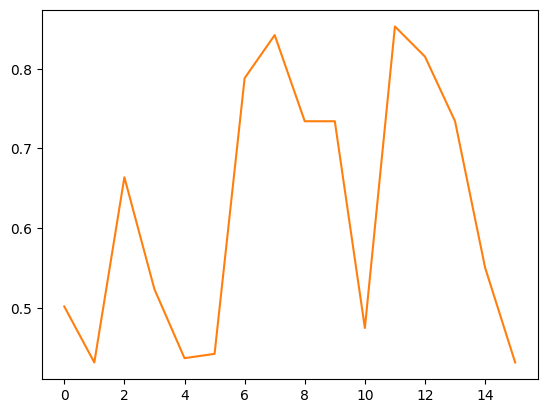

In [78]:
plt.plot(np.array(res))
plt.plot(train.data['y'][10])